# Session 1 
## Changing parameters

Let's begin by importing pybamm and loading the DFN model

In [1]:
import pybamm

In [4]:
model = pybamm.lithium_ion.DFN()

PyBaMM comes with a number of parameter sets which are given AuthorYear names based on the publication they are from. In this notebook we are going to use the parameters from the paper "Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models", Chen et al, JES 2020.

In [5]:
chemistry = pybamm.parameter_sets.Chen2020

The parameter set is a dictionary which contains information about the cell, electrodes, separator and electrolyte. It also contains information about the "experiment" - in this case a 1C constant current discharge from full.

In [6]:
chemistry

{'chemistry': 'lithium_ion',
 'cell': 'LGM50_Chen2020',
 'negative electrode': 'graphite_Chen2020',
 'separator': 'separator_Chen2020',
 'positive electrode': 'nmc_Chen2020',
 'electrolyte': 'lipf6_Nyman2008',
 'experiment': '1C_discharge_from_full_Chen2020',
 'sei': 'example',
 'citation': 'Chen2020'}

We pass the parameter set to the `ParameterValues` class. This creates a dictionary of parameters in the correct format for the simulation

In [7]:
params = pybamm.ParameterValues(chemistry=chemistry)

We can take a look at all the parameters and their values. Note that some parameters are functions

In [8]:
params

{'1 + dlnf/dlnc': 1.0,
 'Ambient temperature [K]': 298.15,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.2594,
 'Cell cooling surface area [m2]': 0.00531,
 'Cell volume [m3]': 2.42e-05,
 'Current function [A]': 5.0,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Nyman2008 at 0x7f0daf82e4c0>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Nyman2008 at 0x7f0daf82e310>,
 'Initial concentration in electrolyte [mol.m-3]': 1000.0,
 'Initial concentration in negative electrode [mol.m-3]': 29866.0,
 'Initial concentration in positive electrode [mol.m-3]': 17038.0,
 'Initial inner SEI thickness [m]': 2.5e-09,
 'Initial outer SEI thickness [m]': 2.5e-09,
 'Initial temperature [K]': 298.15,
 'Inner SEI electron conductivity [S.m-1]': 8.95e-14,
 'Inner SEI l

We can search the parameters to find parameter values we are interested in 

In [9]:
params.search("electrolyte")

EC initial concentration in electrolyte [mol.m-3]	4541.0
Electrolyte conductivity [S.m-1]	<function electrolyte_conductivity_Nyman2008 at 0x7f0daf82e4c0>
Electrolyte diffusivity [m2.s-1]	<function electrolyte_diffusivity_Nyman2008 at 0x7f0daf82e310>
Initial concentration in electrolyte [mol.m-3]	1000.0
Negative electrode Bruggeman coefficient (electrolyte)	1.5
Positive electrode Bruggeman coefficient (electrolyte)	1.5
Separator Bruggeman coefficient (electrolyte)	1.5
Typical electrolyte concentration [mol.m-3]	1000.0


Not all of the parameters are required the model. To take a look at the parameters appearing in a particular model you can do 

In [10]:
model.print_parameter_info()

Maximum concentration in negative electrode [mol.m-3] (Parameter)
Negative electrode thickness [m] (Parameter)
Separator thickness [m] (Parameter)
Positive electrode thickness [m] (Parameter)
Typical current [A] (Parameter)
Number of electrodes connected in parallel to make a cell (Parameter)
Electrode width [m] (Parameter)
Electrode height [m] (Parameter)
Reference temperature [K] (Parameter)
Negative electrode Bruggeman coefficient (electrolyte) (Parameter)
Separator Bruggeman coefficient (electrolyte) (Parameter)
Positive electrode Bruggeman coefficient (electrolyte) (Parameter)
Typical electrolyte concentration [mol.m-3] (Parameter)
Negative electrode electrons in reaction (Parameter)
Maximum concentration in positive electrode [mol.m-3] (Parameter)
Positive electrode electrons in reaction (Parameter)
Initial temperature [K] (Parameter)
Initial concentration in electrolyte [mol.m-3] (Parameter)
Nominal cell capacity [A.h] (Parameter)
Number of cells connected in series to make a ba

This shows us which parameters appear in the model and lets us know if they are constants or functions. For parameters that are function `print_parameter_info` shows what they are functions of (e.g. temperature).

Now we can create a simulation and pass in our parameter values as a keyword argument 

In [11]:
sim = pybamm.Simulation(model, parameter_values=params)

Let's solve and plot

In [12]:
sim.solve([0, 3600])
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=3553.12977501657, step=35.5312977501657), Ou…

As well as changing the entire parameter set you can update individual parameters. Let's take a look at the default value of the "Current function \[A]\" (i.e. the applied current) in the Chen2020 parameter set

In [12]:
params["Current function [A]"]

5.0

The default current is 5A, and this corresponds to a C-rate of 1. Let's double the applied current

In [13]:
params["Current function [A]"] = 10

and create and solve a new simulation using the updated parameter values

In [14]:
new_sim = pybamm.Simulation(model, parameter_values=params)
new_sim.solve([0, 3600])

We can plot the result on its own

In [17]:
new_sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1700.9314030838186, step=17.009314030838187)…

or compare it to the previous result

In [18]:
sols= [sim.solution, new_sim.solution]
labels=["1C", "2C"]
pybamm.dynamic_plot(sols, labels=labels)

interactive(children=(FloatSlider(value=0.0, description='t', max=3553.12977501657, step=35.5312977501657), Ou…

It might be more instructive to plot the voltage as a function of discharge capacity. Let's create a custom plot

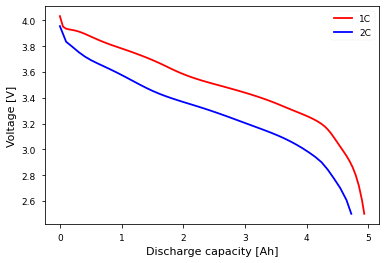

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for solution, label in zip(sols, labels):
    dcap = solution["Discharge capacity [A.h]"].data
    voltage = solution["Terminal voltage [V]"].data
    ax.plot(dcap, voltage, label=label)
ax.set_xlabel("Discharge capacity [Ah]")    
ax.set_ylabel("Voltage [V]")
ax.legend()

From the parameter info we see that the current can depend on time. Let's set up a new simulation where we apply a sinusoidal current. First we define our current function 

In [20]:
import numpy as np 

def my_current(t):
    return -0.1 * pybamm.sin(2*np.pi*t/60)

and then update the parameter values

In [21]:
params["Current function [A]"] = my_current

Finally we create a solve a new simulation. Note here that we pass an array of times instead of a window. This gives us more control over the times the solution is returned at, and lets us make sure there are enough data points to capture the oscillations in the solution 

In [22]:
sin_sim = pybamm.Simulation(model, parameter_values=params)
t_eval = np.arange(0, 181, 1)
sin_sim.solve(t_eval)
sin_sim.plot(["Current [A]", "Terminal voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=179.99999999999997, step=1.7999999999999998)…